- [JPEG 中的范式哈夫曼编码](https://zhuanlan.zhihu.com/p/72044095)
- https://people.cs.nctu.edu.tw/~cjtsai/courses/imc/classnotes/imc14_03_Huffman_Codes.pdf
- https://zhuanlan.zhihu.com/p/102758195
- https://zhuanlan.zhihu.com/p/256410433

C:\Users\BREND\AppData\Local\Temp\ipykernel_32420\461193533.py:796: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  Images.append(imageio.imread(path))
C:\Users\BREND\AppData\Local\Temp\ipykernel_32420\461193533.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  self.image = np.array(imageio.imread(image_path), dtype=np.uint8)


(512, 512, 3)


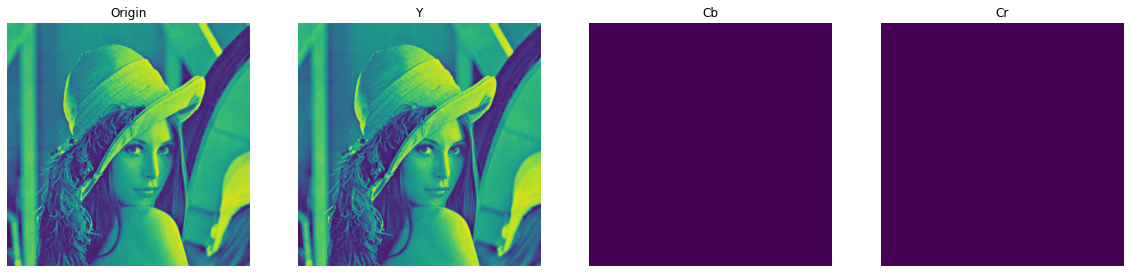

({'date': 1659342252.331059,
  'file_path': 'test_gray_2.jpg',
  'size': (512, 512),
  'quality': 50,
  'file_size': 21100,
  'compression_ratio': '343.77%',
  'run_time': 0.7971041202545166,
  'PSNR': 34.85494147470972},
 0)

In [4]:
import io
import struct
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import imageio
import cv2
import time
from pathlib import Path
from queue import PriorityQueue

from libs.HuffmanTree import HuffmanTree, LimitedLenHuffmanTree
from libs.util import psnr
from libs.JPEGStandardHuffmanTable import STD_HUFTAB_LUMIN_DC, STD_HUFTAB_CHROMIN_DC, STD_HUFTAB_LUMIN_AC, STD_HUFTAB_CHROMIN_AC

class JPEG():
    def __init__(self, image_path):
        self.origin_path = image_path
        self.image = np.array(imageio.imread(image_path), dtype=np.uint8)
        self.image = self.resize_shift_image(self.image, np.ceil(self.image.shape[0]/8)*8, np.ceil(self.image.shape[1]/8)*8)
        self.height = self.image.shape[0]
        self.width = self.image.shape[1]
        if self.image.ndim == 3:
            self.ColorImage = True
            self.channel = 3
            self.image = self.image[:, :, 0:3]
            self.color_components = [
                {'id': 1, "hscale": 1, "vscale": 1, "Quantization_table_index": 0},
                {'id': 2, "hscale": 1, "vscale": 1, "Quantization_table_index": 1},
                {'id': 3, "hscale": 1, "vscale": 1, "Quantization_table_index": 1}
            ]
            self.num_components = [
                {'id': 1, "dc_table": 0, "ac_table": 0},
                {'id': 2, "dc_table": 1, "ac_table": 1},
                {'id': 3, "dc_table": 1, "ac_table": 1}
            ]
        else:
            self.ColorImage = False
            self.channel = 1
            self.image = self.image[:, :]
            self.color_components = [
                {'id': 1, "hscale": 1, "vscale": 1, "Quantization_table_index": 0},
            ]
            self.num_components = [
                {'id': 1, "dc_table": 0, "ac_table": 0},
            ]

        self.fileDtype = np.int32
        self.valueDtype = np.float64
        self.QuantizationTable = [[], []]
        self.mcu_height = max(c['vscale'] for c in self.color_components)*8
        self.mcu_width = max(c['hscale'] for c in self.color_components)*8
        self.zigzag_index = None
        self.HuffmanTableTypeIndex = -1
        self.STD_HuffmanTable = {
            "DC": [[], []],
            "AC": [[], []]
        }
        self.HuffmanTable = {
            "DC": [[], []],
            "AC": [[], []]
        }

    def useDefineTable(self):
        if len(self.STD_HuffmanTable["DC"]) * len(self.STD_HuffmanTable["AC"]) == 0:
            raise Error("huffmanTable is undefined")
        self.HuffmanTableTypeIndex = 1

    def setHuffmanTable(self, isAC, index, table):
        self.STD_HuffmanTable["AC" if isAC else "DC"][index] = table
        self.HuffmanTableTypeIndex = 0

    def resize_shift_image(self, img, height, width):
        h, w = img.shape[:2]
        height = int(height)
        width = int(width)
        lh = (height - h) // 2
        lw = (width - w) // 2
        if img.ndim == 3:
            new_image = np.zeros((height, width, 3), dtype=np.uint8)
            new_image[lh:lh+h, lw:lw+w, :] = img[:, :, :3]
        else:
            new_image = np.zeros((height, width), dtype=np.uint8)
            new_image[lh:lh+h, lw:lw+w] = img[:, :]
        return new_image


    def encode(self, quality=100, save_path="./", isColor=True, block_size=8, finished_info=dict(), showProcessingLog=False):
        self.quality = quality
        self.block_size = block_size

        if isColor & self.ColorImage:
            self.ColorImage = True
            self.channel = 3
            self.color_components = [
                {'id': 1, "hscale": 1, "vscale": 1, "Quantization_table_index": 0},
                {'id': 2, "hscale": 1, "vscale": 1, "Quantization_table_index": 1},
                {'id': 3, "hscale": 1, "vscale": 1, "Quantization_table_index": 1}
            ]
            self.num_components = [
                {'id': 1, "dc_table": 0, "ac_table": 0},
                {'id': 2, "dc_table": 1, "ac_table": 1},
                {'id': 3, "dc_table": 1, "ac_table": 1}
            ]
        else:
            self.ColorImage = False
            self.channel = 1
            self.color_components = [
                {'id': 1, "hscale": 1, "vscale": 1, "Quantization_table_index": 0},
            ]
            self.num_components = [
                {'id': 1, "dc_table": 0, "ac_table": 0},
            ]

        if showProcessingLog:
            print("# (1/7) ImageToYCbCr")
        total_start = start = time.time()
        self._img2ycbcr(isColor=self.ColorImage, showOutput=True)
        if showProcessingLog:
            print("used %.3f sec" % (time.time() - start))
            print("# (2/7) YCbCr DCT")
            start = time.time()
        self._ycbcrDCT()
        if showProcessingLog:
            print("used %.3f sec" % (time.time() - start))
            print("# (3/7) YCbCr Quant")
            start = time.time()
        self._ycbcrQuant()
        if showProcessingLog:
            print("used %.3f sec" % (time.time() - start))
            print("# (4/7) zigzag to MCU")
            start = time.time()
        self._ycbcrZigzag()
        if showProcessingLog:
            print("used %.3f sec" % (time.time() - start))
            print("# (5/7) MCU's DC and AC")
            start = time.time()
        self._DPCMandRLE()
        if showProcessingLog:
            print("used %.3f sec" % (time.time() - start))
            print("# (6/7) Huffman Encoding")
            start = time.time()
        self.HuffmanTableBuilding(HuffmanTableTypeIndex=self.HuffmanTableTypeIndex)
        self._HuffmanEncoding()
        self._EntropyCodedStgment()
        if showProcessingLog:
            print("used %.3f sec" % (time.time() - start))
            print("# (7/7) Write to File")
            start = time.time()
        self._writeToFile(save_path=save_path)
        if showProcessingLog:
            print("used %.3f sec" % (time.time() - start))

        save_image = plt.imread(self.save_path)
        finished_info["date"] = time.time()
        finished_info["file_path"] = self.save_path
        finished_info["size"] = (self.height, self.width)
        finished_info["quality"] = self.quality
        finished_info["file_size"] = Path(self.save_path).stat().st_size
        # finished_info["Huffman Encode Type"] = self.HuffmanTableType[self.HuffmanTableTypeIndex]
        finished_info["compression_ratio"] = "{:.2%}".format(Path(self.origin_path).stat().st_size / finished_info["file_size"])
        finished_info["run_time"] = finished_info["date"] - total_start
        if self.image.ndim == save_image.ndim:
            finished_info["PSNR"] = psnr(self.image, save_image)

        return save_image

    ## 1. YCbCr
    def _img2ycbcr(self, isColor=True, showOutput=False, DEBUG=False):
        if self.image.ndim == 3:
            self.ycbcr = self.__rgb2ycbcr(self.image, isColor=isColor)
        elif self.image.ndim == 2:
            self.ycbcr = self.__gray2ycbcr(self.image)
        if showOutput:
            print(self.ycbcr.shape)
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
            axs[0].set_title("Origin")
            axs[0].imshow(self.image)
            axs[0].axis('off')
            axs[1].set_title("Y")
            axs[1].imshow(self.ycbcr[:, :, 0])
            axs[1].axis('off')
            axs[2].set_title("Cb")
            axs[2].imshow(self.ycbcr[:, :, 1])
            axs[2].axis('off')
            axs[3].set_title("Cr")
            axs[3].imshow(self.ycbcr[:, :, 2])
            axs[3].axis('off')
            plt.show()
        return self.ycbcr

    def __rgb2ycbcr(self, img, isColor=True):
        r,g,b=np.moveaxis(np.copy(img),-1,0)
        y=  ( 0.299*r+0.587*g+0.114*b)
        cb= (-0.168*r-0.331*g+0.499*b)*(1. if isColor else 0)
        cr= ( 0.500*r-0.419*g-0.081*b)*(1. if isColor else 0)
        return np.stack((y,cb,cr),axis=2)

    def __gray2ycbcr(self, img):
        return np.stack((img, np.zeros(img.shape), np.zeros(img.shape)),axis=2)

    ## 2. DCT
    def _ycbcrDCT(self, showOutput=False, DEBUG=False):
        self.dct = np.zeros((self.ycbcr.shape), dtype=self.valueDtype)
        f_image = np.array(self.ycbcr, dtype=self.valueDtype)
        for i in range(0, self.height, self.block_size):
            for j in range(0, self.width, self.block_size):
                for k in range(self.channel):
                    self.dct[i:i+self.block_size, j:j+self.block_size, k] = cv2.dct(f_image[i:i+self.block_size, j:j+self.block_size, k]-(128. if k == 0 else 0))
                    if DEBUG:
                        print("# MCU: ({}, {})".format(i, j))
                        print("## comp:", k, "----------------------------------------------------")
                        print(self.dct[i:i+self.block_size, j:j+self.block_size, k])

        if showOutput:
            fig, axs = plt.subplots(self.channel, 2, figsize=(10, 15))
            for k in range(self.channel):
                axs[k, 0].set_title("{}: Original".format(k))
                axs[k, 0].imshow(self.ycbcr[:, :, 0])
                axs[k, 0].axis('off')
                axs[k, 1].set_title("{}: FDCT".format(k))
                axs[k, 1].imshow(self.dct[:, :, 1])
                axs[k, 1].axis('off')
                # axs[0, 1].imshow(np.log(np.abs(image_dct[:, :, 0])), cmap='gray')
            plt.show()
        return self.dct

    ## 3. Quantization
    ### return qnanted ycbcr
    def _ycbcrQuant(self, showOutput=False, DEBUG=False):
        self.QuantizationTable = self.quantizedTable(self.quality)
        self.quant = np.zeros(self.ycbcr.shape, dtype=self.fileDtype)
        for c in range(self.channel):
            self.quant[:, :, c] = np.around(self.dct[:, :, c]/np.tile(self.QuantizationTable[self.color_components[c]["Quantization_table_index"]], (self.height//8, self.width//8)))

        if showOutput:
            fig, axs = plt.subplots(3, 2, figsize=(10, 15))
            axs[0, 0].set_title("Y - Original")
            axs[0, 0].imshow(self.dct[:, :, 0])
            axs[0, 0].axis('off')
            axs[0, 1].set_title("Y - Quant, PSNR={:.4f}".format(psnr(self.dct[:, :, 0], self.quant[:, :, 0])))
            axs[0, 1].imshow(self.quant[:, :, 0])
            axs[0, 1].axis('off')
            axs[1, 0].set_title("Cb - Original")
            axs[1, 0].imshow(self.dct[:, :, 1])
            axs[1, 0].axis('off')
            axs[1, 1].set_title("Cb - Quant, PSNR={:.4f}".format(psnr(self.dct[:, :, 1], self.quant[:, :, 1])))
            axs[1, 1].imshow(self.quant[:, :, 1])
            axs[1, 1].axis('off')
            axs[2, 0].set_title("Cr - Original")
            axs[2, 0].imshow(self.dct[:, :, 2])
            axs[2, 0].axis('off')
            axs[2, 1].set_title("Cr - Quant, PSNR={:.4f}".format(psnr(self.dct[:, :, 2], self.quant[:, :, 2])))
            axs[2, 1].imshow(self.quant[:, :, 2])
            axs[2, 1].axis('off')
            plt.show()
        return self.quant

    def quantizedTable(self, quality=50):
        std_lumQT = np.array( ## Q_Y: 標準亮度量化表
            [[ 16,  11,  10,  16,  24,  40,  51,  61],
            [ 12,  12,  14,  19,  26,  58,  60,  55],
            [ 14,  13,  16,  24,  40,  57,  69,  56],
            [ 14,  17,  22,  29,  51,  87,  80,  62],
            [ 18,  22,  37,  56,  68, 109, 103,  77],
            [ 24,  35,  55,  64,  81, 104, 113,  92],
            [ 49,  64,  78,  87, 103, 121, 120, 101],
            [ 72,  92,  95,  98, 112, 100, 103,  99]], dtype=self.valueDtype)

        std_chrQT = np.array( ## Q_C: 標準色差量化表
            [[ 17,  18,  24,  47,  99,  99,  99,  99],
            [ 18,  21,  26,  66,  99,  99,  99,  99],
            [ 24,  26,  56,  99,  99,  99,  99,  99],
            [ 47,  66,  99,  99,  99,  99,  99,  99],
            [ 99,  99,  99,  99,  99,  99,  99,  99],
            [ 99,  99,  99,  99,  99,  99,  99,  99],
            [ 99,  99,  99,  99,  99,  99,  99,  99],
            [ 99,  99,  99,  99,  99,  99,  99,  99]], dtype=self.valueDtype)
        
        if(quality < 50):
            qualityScale = 5000 / quality
        else:
            qualityScale = 200 - quality * 2
        
        lumQT = np.array(np.floor((std_lumQT * qualityScale + 50) / 100))
        lumQT[lumQT == 0] = 1
        lumQT[lumQT > 255] = 255
        lumQT = lumQT.reshape([8, 8]).astype(self.fileDtype)
            
        chrQT = np.array(np.floor((std_chrQT * qualityScale + 50) / 100))
        chrQT[chrQT == 0] = 1
        chrQT[chrQT > 255] = 255
        chrQT = chrQT.reshape([8, 8]).astype(self.fileDtype)
        
        return lumQT,chrQT

    ## 4. Zigzag
    ### return zigzag(quant)
    def _ycbcrZigzag(self, showOutput=False, DEBUG=False):
        self.zigzag = []
        self.zigzag_index = self.zigzag_Index(self.block_size)
        block_height = self.mcu_height
        block_width = self.mcu_width
        for i in range(0, self.height, block_height):
            for j in range(0, self.width, block_width):
                comp = []
                for c in range(len(self.color_components)):
                    comp.append(np.array([np.array(self.quant[i:i+block_height, j:j+block_width, c]).flatten()])[:, self.zigzag_index].flatten())
                if DEBUG: print(comp)
                self.zigzag.append(comp)
        return self.zigzag

    def _zigzag(self, block, n):
        index_list = self.zigzag_Index(n)
        return np.array([np.array(block).flatten()])[:, index_list].flatten()

    def zigzag_Index(self, n):
        index_list = np.array([])
        for i in range(n):
            indexs = np.zeros((i+1, 2), dtype=np.uint8)
            indexs[:, 0] = np.arange(i+1) if i % 2 else np.arange(i+1)[::-1]
            indexs[:, 1] = indexs[::-1, 0]
            try:
                index_list = np.concatenate((index_list, indexs))
            except:
                index_list = indexs

        for i in list(reversed(range(n-1))):
            indexs = np.zeros((i+1, 2), dtype=np.uint8)
            indexs[:, 1] = (np.arange(i+1)+n-1-i) if i % 2 == 0 else (np.arange(i+1)+n-1-i)[::-1]
            indexs[:, 0] = indexs[::-1, 1]
            index_list = np.concatenate((index_list, indexs))
        
        return index_list[:, 0] * n + index_list[:, 1]
    def reZigzag_Index(self, n):
        _zigzag = self.zigzag_Index(n)
        if _zigzag.ndim == 2:
            _1Dzig = _zigzag[:, 0]*n + _zigzag[:, 1]
        else:
            _1Dzig = _zigzag
        _reZigzag = sorted(range(len(_1Dzig)), key=lambda k: _1Dzig[k])
        return np.array(_reZigzag)

    ## 5. DC(DPCM) and AC(RLE)
    ## return: the mcu block. (DC, AC)
    def _DPCMandRLE(self, showOutput=False):
        last_DC = np.zeros(len(self.num_components))
        self.MCUs = []
        for mcu in range(len(self.zigzag)):
            newMCU = []
            for comp in range(len(self.zigzag[mcu])):
                ## DPCM
                newMCU_components = dict()
                newMCU_components["DPCM"] = int(self.zigzag[mcu][comp][0]-last_DC[comp])
                # last_DC[comp] = newMCU_components["DPCM"]
                last_DC[comp] = self.zigzag[mcu][comp][0]
                ## RLE
                newMCU_components["RLE"] = self.RLE(self.zigzag[mcu][comp][1:64])

                newMCU.append(newMCU_components)
            self.MCUs.append(newMCU)

        if showOutput:
            print("# MUCs")
            print(self.MCUs)

        return self.MCUs

    def RLE(self, arr):
        rle = []
        unZeroIndex = np.argwhere(arr != 0).flatten()
        last_unZero_Index = 0
        for i in unZeroIndex:
            while(i+1-last_unZero_Index > 16):
                # print("{}:{}, len={}".format(last_unZero_Index, last_unZero_Index+16, 16))
                rle.append((15, 0))
                last_unZero_Index = last_unZero_Index+16
            # print("{}:{}, len={}".format(last_unZero_Index, i+1, i+1-last_unZero_Index))
            rle.append((i-last_unZero_Index, arr[i]))
            last_unZero_Index = i+1
        if last_unZero_Index < 63:
            rle.append((0, 0))
        return np.array(rle, dtype=np.int32)

    ## 6. Huffman
    ### return binary code by mcu blocks
    def _HuffmanEncoding(self, DEBUG=False):
        mcus_encoded = []
        i = 0
        for mcu in self.MCUs:
            i+=1
            if DEBUG: print("## MCU {}".format(i))
            mcus_encoded.append(self.HuffmanEncodingMCU(mcu, DEBUG))
        if DEBUG:
            print("## mcus_encoded")
            pprint(mcus_encoded)
        self.encodedMCUs = "".join(mcus_encoded)
        return self.encodedMCUs

    def HuffmanEncodingMCU(self, mcu, DEBUG=False):
        mcu_encoded = []
        for comp in range(len(mcu)):
            mcu_data = mcu[comp]
            mcu_comp = self.num_components[comp]
            mcu_block = []

            # DPCM
            DPCM = mcu_data["DPCM"]
            code_len, code_word = self.binaryCode(DPCM)
            mcu_block.append(self.HuffmanTable["DC"][mcu_comp["dc_table"]]["{:02x}".format(code_len)] + code_word)

            # RLE
            RLE = mcu_data["RLE"]
            rle_encoded = self.AC_encoding(RLE, mcu_comp["ac_table"], split=DEBUG)
            if DEBUG:
                mcu_block.append("".join(rle_encoded))

                ## debug info
                print("## DPCM")
                print("###", DPCM)
                print("## RLE")
                for rle_index in range(len(RLE)):
                    print("### RLE[{}]: {} => {}".format(rle_index, RLE[rle_index], rle_encoded[rle_index]))
            else:
                mcu_block.append(rle_encoded)
            mcu_encoded.append("".join(mcu_block))
        if DEBUG: 
            print("# mcu_encoded", mcu_encoded)
        return ''.join(mcu_encoded)

    def AC_encoding(self, rle_arr, AC_Table_index, split=False):
        ac_encoded = []
        for rle in rle_arr:
            size, word = self.binaryCode(rle[1])
            run = rle[0]
            hcode = self.HuffmanTable["AC"][AC_Table_index]["{}{}".format(hex(run)[-1], hex(size)[-1])]
            if run == 0 and size == 0:
                word = ""
            
            ac_encoded.append(hcode + word)
        if split:
            return ac_encoded
        else:
            return "".join(ac_encoded)



    ### Encode prepare
    def _EntropyCodedStgment(self, codelen=8):
        perfect_len = (len(self.encodedMCUs)+codelen-1) // codelen
        perfect_code = self.encodedMCUs + '1'*(perfect_len*codelen-len(self.encodedMCUs))
        split_perfect_code = re.findall(r".{8}", perfect_code)
        self.ECS = []
        for code in split_perfect_code:
            self.ECS.append(code)
            if code == "1"*8:
                self.ECS.append("0"*8)
        
        return self.ECS

    ## 7. Write to file
    def _writeToFile(self, file_name=None, save_path="./", DEBUG=False):
        def SOI():
            SOI = io.BytesIO()
            SOI.write(b'\xFF\xD8')
            return SOI

        def APP0():
            APP0 = io.BytesIO()
            APP0.write(b'\xFF\xE0') ## Marker
            APP0.write(struct.pack('>H', 16)) ## Length
            APP0.write(struct.pack('5s', b"JFIF\0")) ## identifier
            APP0.write(struct.pack('>B', 1)) ## JFIF version 1
            APP0.write(struct.pack('>B', 1)) ## JFIF version .1
            APP0.write(struct.pack('>B', 1)) ## units
            APP0.write(struct.pack('>H', 96)) ## x-density
            APP0.write(struct.pack('>H', 96)) ## y-density
            APP0.write(struct.pack('>B', 0)) ## x-thumbnail
            APP0.write(struct.pack('>B', 0)) ## y-thumbnail
            return APP0

        def DQT(QT_infomation, QTable):
            DQT = io.BytesIO()
            DQT.write(b'\xFF\xDB') ## Marker
            DQT.write(struct.pack('>H', 2+1+len(QTable.flatten()))) ## Length((2))
            DQT.write(struct.pack('>B', QT_infomation)) ## 0: luminance((1))
            for quantization in self._zigzag(block=QTable, n=self.block_size): ## ((64))
                DQT.write(struct.pack('>B', quantization))
            return DQT

        def SOF():
            SOF = io.BytesIO()
            SOF.write(b'\xFF\xC0') ## Marker
            SOF.write(struct.pack('>H', 2+1+2+2+1+len(self.color_components)*3)) ## Length
            SOF.write(struct.pack('>B', 8)) ## 8: precision
            SOF.write(struct.pack('>H', self.height)) ## height
            SOF.write(struct.pack('>H', self.width)) ## width
            SOF.write(struct.pack('>B', len(self.color_components))) ## component count
            for color_comp in self.color_components:
                SOF.write(struct.pack('>B', color_comp["id"]))
                SOF.write(struct.pack('>B', color_comp["hscale"]*0x10 + color_comp["vscale"]*0x01))
                SOF.write(struct.pack('>B', color_comp["Quantization_table_index"]))
            return SOF

        def HuffmanTable2FileStructure(huffmanTable, isAC=True, DEBUG=False):
            bitsCount = np.zeros((16), dtype=np.uint8)
            sorted_table = dict(sorted(huffmanTable.items(), key=lambda x: (len(x[1]), x[1])))
            if DEBUG:
                print("[DEBUG] sorted_table")
                print(sorted_table)
            codes = [[] for i in range(16)]

            for code in sorted_table.items():
                if DEBUG:
                    print("val={}, code={}, len={}".format(code[0], code[1], len(code[1])))
                bitsCount[len(code[1])-1] += 1
                hexCode = int(code[0], 16)
                codes[len(code[1])-1].append(hexCode)
            return bitsCount, codes
        def DHT(HuffmanTable, table_id, isAC, DEBUG=False):
            if DEBUG:
                print("# [DEBUG]", "{}".format("AC" if isAC else "DC"), "id={}".format(table_id))
                print("## HuffmanTable")
                print(HuffmanTable)
            
            bitsCount, codes = HuffmanTable2FileStructure(HuffmanTable, isAC, DEBUG)

            DHT = io.BytesIO()
            DHT.write(b'\xFF\xC4')
            DHT.write(struct.pack('>H', 2+1+16+bitsCount.sum()))
            DHT.write(struct.pack('>B', isAC*0x10 + table_id*0x01))
            DHT.write(struct.pack('16B', *bitsCount))
            if DEBUG:
                print("## codes")
                print(codes)
            for len_codes in codes:
                for code in len_codes:
                    DHT.write(struct.pack('>B', code))
            return DHT

        def SOS(num_comps, ecs_list):
            SOS = io.BytesIO()
            SOS.write(b'\xFF\xDA')
            SOS.write(struct.pack('>H', 2+1+len(num_comps)*2+1+2))
            SOS.write(struct.pack('>B', len(num_comps)))
            for num_comp in num_comps:
                # print(num_comp)
                SOS.write(struct.pack('>B', num_comp["id"]))
                SOS.write(struct.pack('>B', num_comp["dc_table"]*0x10 + num_comp["ac_table"]*0x01))
            SOS.write(struct.pack('>H', 63)) ## spectral select
            SOS.write(struct.pack('>B', 0)) ## successive approx.
            for ecs_block in ecs_list:
                SOS.write(struct.pack('>B', int(ecs_block, 2)))
            return SOS

        def EOI():
            EOI = io.BytesIO()
            EOI.write(b'\xFF\xD9')
            return EOI

        soi = SOI()
        if DEBUG:
            print("## SOI")
            print(soi.getvalue())
        
        app0 = APP0()
        if DEBUG:
            print("## APP0")
            print(app0.getvalue())
        
        dqt1 = DQT(0, self.QuantizationTable[0])
        if DEBUG:
            print("## DQT 1")
            print(dqt1.getvalue())
        
        dqt2 = DQT(1, self.QuantizationTable[1])
        if DEBUG:
            print("## DQT 2")
            print(dqt2.getvalue())

        sof = SOF()
        if DEBUG:
            print("## SOF")
            print(sof.getvalue())
        dht_DEBUG = False
        dht_dc0 = DHT(self.HuffmanTable["DC"][0], 0, False, DEBUG=dht_DEBUG)
        if DEBUG:
            print("## DHT DC 0")
            print(dht_dc0.getvalue())
        
        dht_ac0 = DHT(self.HuffmanTable["AC"][0], 0, True, DEBUG=dht_DEBUG)
        if DEBUG:
            print("## DHT AC 0")
            print(dht_ac0.getvalue())
        
        if self.ColorImage:
            dht_dc1 = DHT(self.HuffmanTable["DC"][1], 1, False, DEBUG=dht_DEBUG)
            if DEBUG:
                print("## DHT DC 1")
                print(dht_dc1.getvalue())
            
            dht_ac1 = DHT(self.HuffmanTable["AC"][1], 1, True, DEBUG=dht_DEBUG)
            if DEBUG:
                print("## DHT AC 1")
                print(dht_ac1.getvalue())
        
        sos = SOS(self.num_components, self.ECS)
        if DEBUG:
            print("## SOS")
            print(sos.getvalue())
        
        eoi = EOI()
        if DEBUG:
            print("## EOI")
            print(eoi.getvalue())

        pth = Path(save_path)
        if pth.is_dir():
            # print("[DEBUG] is DIR")
            # print("pth", str(pth))
            spth = pth / "{}_Q{}.jpg".format(Path(self.origin_path).stem, self.quality)
            # self.save_path = str(pth.with_name("{}_Q{}.jpg".format(Path(self.origin_path).stem, self.quality)))
            self.save_path = spth
            # print("self.save_path", self.save_path)
        else:
            # print("[DEBUG] not DIR")
            # print("pth", str(pth))
            spth = pth.parent / (pth.name + ".jpg")
            self.save_path = str(spth)
        # if file_name is None:
        #     self.save_path = "{}{}_Q{}.jpg".format(save_path, Path(self.origin_path).stem, self.quality)
        # else:
        #     self.save_path = "{}{}.jpg".format(save_path, file_name)

        with open(self.save_path, "wb") as f:
            f.write(soi.getbuffer())
            f.write(app0.getbuffer())
            f.write(dqt1.getbuffer())
            f.write(dqt2.getbuffer())
            f.write(sof.getbuffer())
            f.write(dht_dc0.getbuffer())
            f.write(dht_ac0.getbuffer())
            if self.ColorImage:
                f.write(dht_dc1.getbuffer())
                f.write(dht_ac1.getbuffer())
            f.write(sos.getbuffer())
            f.write(eoi.getbuffer())
        return True

    def generateHuffmanTable(self, freq_Table):
        huffmanTable = HuffmanTree(freq_Table).value_to_bitstring_table()
        huffmanTable = list(huffmanTable.items())
        huffmanTable.sort(key=lambda x: len(x[1]))
        # print("[DEBIG]", huffmanTable)
        return huffmanTable

    def toJPEGHuffmanTable(self, HuffmanTable, DEBUG=False):
        JPEG_HuffmanTable = {}
        if len(HuffmanTable) == 0:
            return JPEG_HuffmanTable
        code_len = len(HuffmanTable[0][1])
        code_val = 0b0
        for i in range(len(HuffmanTable)):
            key, code = HuffmanTable[i]
            if DEBUG:
                print(key, len(code))
            if code_len != len(code):
                code_val <<= (len(code)-code_len)
                code_len = len(code)
            elif i == len(HuffmanTable)-1:
                code_val = code_val << 1 if code_len < 16 else code_val+1
            JPEG_HuffmanTable[key] = "{:0{}b}".format(code_val, len(code))
            code_val+=1
        
        return JPEG_HuffmanTable

    def generateJPEGHuffmanTable(self, freq_Table, DEBUG=False):
        if DEBUG:
            print("=============================== [toJPEGHuffmanTable] ===============================")
        Best_HuffmanTree = HuffmanTree(freq_Table)
        if Best_HuffmanTree.mostLongCodeLen() <= 15:
            return Best_HuffmanTree.create_huffman_table()
        else:
            Average_HuffmanTree = LimitedLenHuffmanTree(freq_Table)
            return Average_HuffmanTree.create_huffman_table()

    def stat_WordFreq(self):
        stat_DCs = [[] for _ in range(max([comp["dc_table"] for comp in self.num_components])+1)]
        stat_ACs = [[] for _ in range(max([comp["ac_table"] for comp in self.num_components])+1)]
        i = 0
        for mcu in self.MCUs:
            i+=1
            # print("#", i)
            for comp_index in range(len(mcu)):
                # print("##", comp_index)
                comp = mcu[comp_index]
                # print(comp)
                # print("DPCM", "{:02x}".format(self.binaryCode(comp["DPCM"])[0]))
                stat_DCs[self.num_components[comp_index]["dc_table"]].append("{:02x}".format(self.binaryCode(comp["DPCM"])[0]))
                j = 0
                for rle in comp["RLE"]:
                    j+=1
                    # print("RLE {}:".format(j), "{}{}".format(hex(rle[0])[-1], hex(self.binaryCode(rle[1])[0])[-1]))
                    stat_ACs[self.num_components[comp_index]["ac_table"]].append("{}{}".format(hex(rle[0])[-1], hex(self.binaryCode(rle[1])[0])[-1]))

        return stat_DCs, stat_ACs

    def calc_WordFreq(self):
        stat_DCs, stat_ACs = self.stat_WordFreq()
        freq_DCs = [{} for _ in range(max([comp["dc_table"] for comp in self.num_components])+1)]
        freq_ACs = [{} for _ in range(max([comp["ac_table"] for comp in self.num_components])+1)]
        for i in range(len(stat_DCs)):
            for j in range(len(stat_DCs[i])):
                if stat_DCs[i][j] in freq_DCs[i]:
                    freq_DCs[i][stat_DCs[i][j]] += 1
                else:
                    freq_DCs[i][stat_DCs[i][j]] = 1
        for i in range(len(stat_ACs)):
            for j in range(len(stat_ACs[i])):
                if stat_ACs[i][j] in freq_ACs[i]:
                    freq_ACs[i][stat_ACs[i][j]] += 1
                else:
                    freq_ACs[i][stat_ACs[i][j]] = 1
        return freq_DCs, freq_ACs

    def estimatedHuffmanEncoded(self, freq_Table, huffmanTable):
        total_wordlen = 0
        for key, freq in freq_Table.items():
            total_wordlen += len(huffmanTable[key]*freq)
        return total_wordlen

    ## return the True is meaning that huffmanTable1 is better
    def comparedBestCompressTable(self, freq_Table, huffmanTable1, huffmanTable2):
        tb1_compress_size = self.estimatedHuffmanEncoded(freq_Table, huffmanTable1)
        tb2_compress_size = self.estimatedHuffmanEncoded(freq_Table, huffmanTable2)
        return tb1_compress_size < tb2_compress_size

    def HuffmanTableBuilding(self, HuffmanTableTypeIndex):
        # print("[DEBUG] # HuffmanTableBuilding")
        freq_DCs, freq_ACs = self.calc_WordFreq()
        HuffmanTable = {"DC":[], "AC":[]}
        HuffmanTable["DC"] = [self.generateJPEGHuffmanTable(freq_DCs[i]) for i in range(len(freq_DCs))]
        HuffmanTable["AC"] = [self.generateJPEGHuffmanTable(freq_ACs[i]) for i in range(len(freq_ACs))]
        if HuffmanTableTypeIndex == 0:
            for i in range(min(len(HuffmanTable["DC"]), len(self.HuffmanTable["DC"]))):
                if self.comparedBestCompressTable(freq_DCs[i], HuffmanTable["DC"][i], self.STD_HuffmanTable["DC"][i]):
                    self.HuffmanTable["DC"][i] = HuffmanTable["DC"][i]
                else:
                    self.HuffmanTable["DC"][i] = self.STD_HuffmanTable["DC"][i]
            for i in range(min(len(HuffmanTable["AC"]), len(self.HuffmanTable["AC"]))):
                if self.comparedBestCompressTable(freq_ACs[i], HuffmanTable["AC"][i], self.STD_HuffmanTable["AC"][i]):
                    self.HuffmanTable["AC"][i] = HuffmanTable["AC"][i]
                else:
                    self.HuffmanTable["AC"][i] = self.STD_HuffmanTable["AC"][i]
        elif HuffmanTableTypeIndex == 1: ## use Define Table
            self.HuffmanTable["DC"] = self.STD_HuffmanTable["DC"]
            self.HuffmanTable["AC"] = self.STD_HuffmanTable["AC"]
            # return
        else:
            self.HuffmanTable["DC"] = HuffmanTable["DC"]
            self.HuffmanTable["AC"] = HuffmanTable["AC"]


    # return
    ## 1. length 
    ## 2. en
    def binaryCode(self, x):
        if x > 0:
            vli = self.binaryCodeLength(x)
            return vli, np.binary_repr(x, vli)
        elif x < 0:
            vli = self.binaryCodeLength(abs(x))
            return vli, np.binary_repr(2**vli-1+x, vli)
        else: ## Zero Run Length
            return 0, ""
    
    def binaryCodeLength(self, n):
        if n<2:
            return 1
        else:
            return np.floor(np.log2(n)+1).astype(np.uint8)

Image_set = dict(
    # cover = "../_Dataset/Lenna/lena_color.gif"
    gray = "./test_gray.jpg"
)

Images_name = []
Images = []
Images_path = []
Images_len = 0
for name, path in Image_set.items():
    Images_name.append(name)
    Images.append(imageio.imread(path))
    Images_path.append(path)
    Images_len += 1

jpeg = JPEG(image_path = Images_path[0])
jpeg.setHuffmanTable(isAC=False, index=0, table=STD_HUFTAB_LUMIN_DC())
jpeg.setHuffmanTable(isAC=False, index=1, table=STD_HUFTAB_CHROMIN_DC())
jpeg.setHuffmanTable(isAC=True, index=0, table=STD_HUFTAB_LUMIN_AC())
jpeg.setHuffmanTable(isAC=True, index=1, table=STD_HUFTAB_CHROMIN_AC())
# jpeg.useDefineTable()
# jpeg.HuffmanTableTypeIndex = 2
log = dict()
jpeg.encode(quality=50, isColor=False, save_path="./test_gray_2", finished_info=log)
log, jpeg.HuffmanTableTypeIndex

C:\Users\BREND\AppData\Local\Temp\ipykernel_25564\4217577086.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  axs[i//fig_h, i%fig_h].imshow(imageio.imread(self.images[i]))


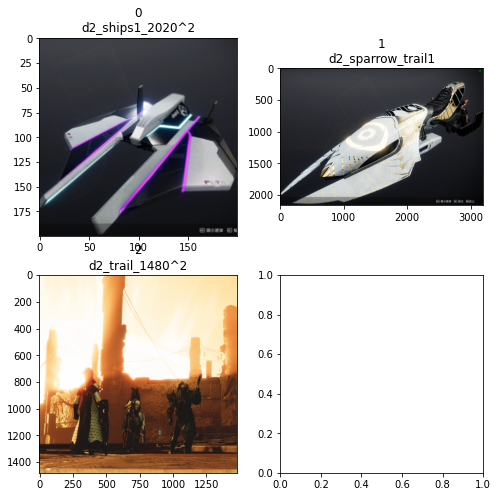

In [5]:
from datetime import datetime as dt
from pathlib import Path
from tqdm import tqdm, trange
import os

class JPEG_Tester:
    def __init__(self, taskName="{}".format(dt.now().strftime("%Y%m%d_%H.%M.%S")), save_path=None):
        if save_path is None:
            self.save_path = "./{}/".format(taskName)
        else:
            self.save_path = save_path
        self.taskName = taskName
        self.images = []
        self.imagesLen = 0
        self.testImageIndex_list = []
        self.testQuality_list = []
        self.clear_logData()

    def loadDataSet(self, path="./"):
        p = Path(path)
        self.images = list(p.glob('*.*'))
        self.imagesLen = len(self.images)

    def showDataSet(self):
        fig_h = int(np.ceil(np.sqrt(self.imagesLen)))
        # print("image len", self.imagesLen)
        # print("image h", fig_h)
        fig, axs = plt.subplots(fig_h, fig_h, figsize=(fig_h*4, fig_h*4))

        for i in range(self.imagesLen):
            # print(i, i//fig_h, i%fig_h)
            axs[i//fig_h, i%fig_h].imshow(imageio.imread(self.images[i]))
            axs[i//fig_h, i%fig_h].set_title("{}\n{}".format(i, Path(self.images[i]).stem))
        plt.show()

    def tryBuildSaveDir(self, path=None):
        if path is not None:
            self.save_path = path
        try:
            os.mkdir(self.save_path)
        except FileExistsError:
            pass

    def clear_logData(self):
        self.source_fileNames = []
        self.filePaths = []
        self.sizes = []
        self.qualitys = []
        self.psnrs = []
        self.fileSizes = []
        self.compression_ratio_list = []
        self.runTimes = []

    def saveTestLog(self):
        self.tryBuildSaveDir()
        self.testLogdf.to_excel("JPEG Tester Task {}.xlsx".format(self.taskName)) 

    def generateRandomTestParameter(self, testRound=0, QualityRange=[0, 100]):
        self.runCount = self.imagesLen if testRound == 0 else testRound
        self.testImageIndex_list = np.random.permutation(max(testRound, self.imagesLen))[:self.runCount] % self.imagesLen
        if isinstance(QualityRange, int):
            QualityRange = [QualityRange, QualityRange]
        self.testQuality_list = np.random.randint(QualityRange[0], QualityRange[1], self.runCount)

    def generateTestParameter(self, imageIndex_list, Quality_list):
        self.testImageIndex_list = imageIndex_list
        self.testQuality_list = Quality_list
        if len(self.testImageIndex_list) != len(self.testQuality_list):
            raise ValueError("imageIndex_list and Quality_list must have the same length")
        self.runCount = len(self.testImageIndex_list)

    def run(self, useDefineTable=False):
        self.tryBuildSaveDir()
        for rC in trange(self.runCount):
            # print(self.testImageIndex_list[rC], self.testQuality_list[rC])
            fileP = Path(self.images[self.testImageIndex_list[rC]])
            jpeg = JPEG(self.images[self.testImageIndex_list[rC]])
            jpeg.setHuffmanTable(isAC=False, index=0, table=STD_HUFTAB_LUMIN_DC())
            jpeg.setHuffmanTable(isAC=False, index=1, table=STD_HUFTAB_CHROMIN_DC())
            jpeg.setHuffmanTable(isAC=True, index=0, table=STD_HUFTAB_LUMIN_AC())
            jpeg.setHuffmanTable(isAC=True, index=1, table=STD_HUFTAB_CHROMIN_AC())
            program_Log = dict()
            jpeg.encode(self.testQuality_list[rC], save_path=self.save_path, finished_info=program_Log)
            self.source_fileNames.append(fileP.stem)
            self.filePaths.append(program_Log["file_path"])
            self.sizes.append(program_Log["size"])
            self.qualitys.append(program_Log["quality"])
            self.psnrs.append(program_Log["PSNR"])
            self.fileSizes.append(program_Log["file_size"])
            self.compression_ratio_list.append(program_Log["compression_ratio"])
            self.runTimes.append(program_Log["run_time"])
        
        self.testLogdf = pd.DataFrame({
            "source file": self.source_fileNames, 
            "size": self.sizes, 
            "quality": self.qualitys, 
            "psnr": self.psnrs, 
            "file size": self.fileSizes,
            "compression ratio": self.compression_ratio_list,
            "runTime": self.runTimes,
            "file path": self.filePaths
        })

        return self.testLogdf

tester = JPEG_Tester()
tester.loadDataSet("../_Dataset/Destiny2/")
tester.showDataSet()

In [6]:
tester.clear_logData()
# tester.generateTestParameter(
#     imageIndex_list=[16], 
#     Quality_list=[7]
# )

# tester.generateRandomTestParameter(1)
tester.generateTestParameter([1], [75])
df = tester.run()
# df = tester.run(useDefineTable=True)
# df = tester.randomTest(300)
# tester.saveTestLog()
df

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\BREND\AppData\Local\Temp\ipykernel_25564\2008121220.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  self.image = np.array(imageio.imread(image_path), dtype=np.uint8)
  0%|          | 0/1 [00:16<?, ?it/s]
C:\Users\BREND\AppData\Local\Temp\ipykernel_25564\2008121220.py:640: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(HuffmanTable) is 0:
C:\Users\BREND\AppData\Local\Temp\ipykernel_25564\2008121220.py:640: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(HuffmanTable) is 0:


OSError: broken data stream when reading image file

In [100]:
df

,source file,size,quality,psnr,file size,compression ratio,runTime,file path
0,pngaaa.com-4785430_320,"(320, 320)",100,55.339252,31824,1287.51%,0.739997,test\pngaaa.com-4785430_320_Q100.jpg


In [21]:
# df.to_excel("Stress_20220712.xlsx") 
tester.saveTestLog()